In [1]:
import numpy as np
import os
import datetime 
import scipy.constants as constants

# Tao
from pytao import Tao

#BO
from bayes_opt import BayesianOptimization

# openPMD-beamphysics
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import twiss_match, matched_particles
from pmd_beamphysics.statistics import slice_statistics, twiss_dispersion_calc
from pmd_beamphysics.plot import slice_plot, marginal_plot, density_and_slice_plot
from h5py import File

# FEL parametrization
from fel_mx_model import resonantLambda, rhoFEL, gainLength1D, getLambdaMX, gainLength,\
                         Pbeam, Psat, Pz, shot_noise

# LCLS and physics params
from constants import m_e, e, c, hc, markers, z, K_u, lambda_u, I_A

# nicer plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)
plt.rcParams.update({'font.size': 14})

# useful for debugging
%load_ext autoreload
%autoreload 2

# Initialize Tao

In [2]:
# create ParticleGroup from bmad h5 particle data
directory = './beam_undulator_data/'

save_beam = False

l1_phase_init, l1x_phase_init, l2_phase_init = -21.5, -160.0, -33.5

### Change input params functions for objective

In [45]:
def beamOn(n_particle, l1_phase, l1x_phase, l2_phase):
    
    tao.cmd(f'snparticle {n_particle}')
    tao.cmd('beamon')
    
    # collimator to get rid of horns
    tao.cmd('set ele CE11 x1_limit = 0.0015 ;set ele CE11 x2_limit = 0.0035')
    
    # start with L1, L1X and L2 phases
    tao.cmd(f'set ele O_L1 phase_deg={l1_phase}')
    tao.cmd(f'set ele K21_2 phase_deg={l1x_phase}')
    tao.cmd(f'set ele O_L2 phase_deg={l2_phase}')

In [29]:
def saveBeam():
    #timestamp = '07-07_10-30'
    #timestamp = '08-08_10-30'
    #timestamp = (datetime.datetime.now()).strftime("%m-%d_%H-%M")
    timestamp = '08-15_17-39'
    # need to log settings for bmad somewhere here?
    
    # Beam data along undulator
    P_data= {}
    
    # write beam at each marker in undulator
    for i,marker in enumerate(markers):
        tao.cmd(f'write beam -at {marker} ./beam_undulator_data/lcls_beam_{i}_{marker}_{timestamp}.h5')
    
    # need to figure out how to pass it here without h5 files to make it faster?
    for i,marker in enumerate(markers):
        filename = f'lcls_beam_{i}_{marker}_{timestamp}.h5'
        P_data[f'{marker}'] = ParticleGroup(directory+filename)   
        
    # collimation loses some particles, take only alive particles here
    for beam in P_data:
        P_data[beam] = P_data[beam].where(P_data[beam].status==1) # status 1 is alive
        n_part_alive = P_data[beam].n_alive
        
    if save_beam == False:
        os.system(f"rm -f ./beam_undulator_data/lcls_beam_*_{timestamp}.h5")
    return P_data, n_part_alive
        

### util fns

In [30]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1

# Objective measurement is full Psat calc below

In [95]:
# try to cut based on P vals from P_data
#P_data_edited = np.where(P_data['VVHXU19']['delta_t']< P_data['VVHXU19']['delta_t'][np.argmin(P_data['VVHXU19']['delta_pz'])], P_data['VVHXU19']['delta_pz'], P_data['VVHXU19']['delta_pz']*0 )

In [49]:
def evaluate(var1, var1x, var2):
  
    # init outside loop for the runtime error
    init = '-init ./tao.init -noplot'
    # Make tao instance
    tao=Tao(init)   
    
    try:
        # n_particle, l1_phase, l1x_phase, l2_phase
        beamOn(1500, var1, var1x, var2)
    except RuntimeError:
        print("Passing RuntimeError")
        pass

    P_data, n_part_alive = saveBeam()
    ###############
    # plot example 
    P_data['VVHXU19'].plot('delta_t', 'delta_pz')
    
    # I NEED TO BREAK THESE UP INTO FUNCTIONS BUT FOR NOW THIS IS FINE
    ################
    slices = {}
    n_slice = int(n_part_alive/30) # how to determine denominator automatically?

    ## getting sliced stats for beam at each marker (along z)
    for i,marker in enumerate(markers):
        P = P_data[f'{marker}'] 
        slices[marker] = slice_statistics(P, \
                                keys=["sigma_pz","mean_pz","average_current","norm_emit_x","norm_emit_y",\
                                      "mean_px", "mean_x", "mean_py", "mean_y", "sigma_x", "sigma_y"], \
                                n_slice= n_slice, slice_key='t')   
    ################
    #fig, ax = plt.subplots(3, sharex=True, figsize=(10,13))
#     sl = slices["VVHXU19"]

#     #plt.plot(sl['norm_emit_x']*10**(9), label=r"$\epsilon_x$")
#     #plt.plot(sl['norm_emit_y']*10**(9), label=r"$\epsilon_y$")
#     plt.plot(sl['average_current']*10**(-3), label=r"$I_{avg}$")
#     plt.plot(sl['sigma_pz']*10**(-7), label=r"$\sigma_{p_z}$")
#     plt.title("Und, collimated")

#     plt.legend()

    #plt.ylim(0,5)
    ### energy spread is large because of the weird line shaped horns
    #############
    time_slice = (P.t.max()-P.t.min())/n_slice
    ##############
    # find 3D gain length
    # instant growth rate (Lg) at each marker for each slice
    lg_slice = []

    for i,marker in enumerate(markers):

        # particle group/slice
        sl = slices[marker]
        P = P_data[marker] 

        # emittances
        norm_emit_x = sl["norm_emit_x"]
        norm_emit_y = sl["norm_emit_y"]

        # average current
        current_beam = sl["average_current"]
        #current_beam = 3*1e3 if sl["average_current"][i]>3*1e3 else sl["average_current"][i]

        # energy spread
        sig_pz = sl["sigma_pz"]#/19 # adjusted just to test, take real one here after fixing horns!!!!!!!!!!!!!
        #sig_pz = [0.5*1e7 if x>0.5*1e7 else x for x in sl["sigma_pz"]] # adjusted just to test, take real one here after fixing horns!!!!!!!!!!!!!
        mean_pz = sl["mean_pz"]

        # gamma relativistic
        gamma_beam = sl["mean_pz"]/P.mass 

        # normalization factor for each slice ---> is this correct or is it beta*gamma?????????????????????
        norm_fac_mult = gamma_beam 

        # unnormalized emittances
        un_emit_x = norm_emit_x/norm_fac_mult # [m]
        un_emit_y = norm_emit_y/norm_fac_mult

        # beam sizes
        sig_x = sl["sigma_x"]
        sig_y = sl["sigma_y"]

        # geom size
        sizes = np.sqrt(sig_x*sig_y) #check for MX assumptions: assymmetric beam size?????????????????????

        # geom emittance (not normalized)
        emittance = np.sqrt(un_emit_x * un_emit_y)

        # radiation wavelength
        lambda_rad = resonantLambda(gamma_beam, K_u, lambda_u)

        # FEL parameter
        rho = rhoFEL(current_beam, sizes, gamma_beam)

        # get instant. Lg
        Lg1D = gainLength1D(rho, lambda_u)

        # Ming Xie
        LambdaMX = getLambdaMX(Lg1D, sizes, lambda_rad, emittance, lambda_u, sig_pz, mean_pz)
        Lg = gainLength(Lg1D, LambdaMX)

        # append to list
        lg_slice.append(Lg)  
        
    ######
    # find z location reached 18Lg
    # Get z distance between markers (dZ)
    dZ = [0]*len(z)

    for i,loc in enumerate(z):
        dz = loc-z[i-1]

        if dz == 0 or i ==0:
            dz = 0 
        dZ[i] = dz

    lg_cumul_slice = [] # gain lengths so far for each slice
    zsat = [] # z at saturation
    zsat_idx = [] # index of z list at saturation

    for j in range(n_slice):
        fracLgcum = 0
        satQ = False
        list_lg_cum = [] # for each slice get Lg along z

        for i, instLg in enumerate(lg_slice):
            # at this location in und, get number of gain lengths so far
            fracLg = dZ[i]/instLg[j] # dist since last marker in fractions of Lg at this marker
            Lgcum = fracLg + fracLgcum # increment to find 18Lg marker location
            fracLgcum = Lgcum
            list_lg_cum.append(Lgcum)

            if fracLgcum > 18 and satQ == False:
                satQ = True
                #print(f"saturated at z = {z[i]}, marker = {markers[i]}")
                zsat.append(z[i])
                zsat_idx.append(i)
                
        if satQ == False:
            n_slice -= 1
            print(f"slice {j} did not saturate.")

        lg_cumul_slice.append(list_lg_cum)    

#     plt.figure(figsize=(15,7))

#     for i in range(n_slice):
#         # plot cumulative Lg for each slice along undulator
#         plt.plot(z, lg_cumul_slice[i], alpha=0.5)

#     # saturation point
#     plt.hlines(18, 0, 160, linestyle="--", color="black", label="Saturation (18L$_g$)")

#     plt.legend()
#     plt.ylabel(r"Cumul. L$_g$ [m]");
#     plt.xlabel("z (m)");    

    #############
    # find saturation power
    # get avg Lg for each slice from saturation point
    lg_avg = []

    #for i in range(n_slice): # SOME DON'T SATURATE HERE
    for i in range (len(zsat)):
        lg_avg.append(zsat[i]/18) # wait is this correct?

    p_shotnoise_list, rho_list, psat_list, mean_pz_list, current_list, sizes_list, lambda_rad_list = \
    [], [], [], [], [], [], []

    # loop over slices at the point where each saturates
    for i in range(n_slice):
        # z along und where saturation happens
        
        sl = slices[markers[zsat_idx[i]]]           
        P = P_data[markers[zsat_idx[i]]]

        # emittances
        norm_emit_x = sl["norm_emit_x"][i]
        norm_emit_y = sl["norm_emit_y"][i]

        # average current
        current_beam = sl["average_current"][i]
        #current_beam = 3*1e3 if sl["average_current"][i]>3*1e3 else sl["average_current"][i]

        current_list.append(current_beam)

        # energy spread
        sig_pz = sl["sigma_pz"][i]#/19 # need to adjust later !!!!!!!!!!!!!!!!!!!!!!
        #sig_pz = 0.5*1e7 if sl["sigma_pz"][i]>0.5*1e7 else sl["sigma_pz"][i]
        mean_pz = sl["mean_pz"][i]
        mean_pz_list.append(mean_pz)

        # gamma relativistic
        gamma_beam = sl["mean_pz"][i]/P.mass 

        # unnormalized emittances
        un_emit_x = norm_emit_x/norm_fac_mult[i] # [m]
        un_emit_y = norm_emit_y/norm_fac_mult[i]
        emittance = np.sqrt(un_emit_x * un_emit_y)

        sig_y = sl["sigma_y"][i]
        sig_x = sl["sigma_x"][i]


        sizes = np.sqrt(sig_x*sig_y)
        sizes_list.append(sizes)

        # get inst Lg
        lambda_rad = resonantLambda(gamma_beam, K_u, lambda_u)
        lambda_rad_list.append(lambda_rad)

        rho = rhoFEL(current_beam, sizes, gamma_beam)
        rho_list.append(rho)
        Lg1D = gainLength1D(rho, lambda_u)

        p_shotnoise_list.append(shot_noise(rho, lambda_rad, current_beam, gamma_beam))
        pbeam = Pbeam(gamma_beam, current_beam)

        # not sure if correct to us 3DLg in MX factor?
        LambdaMX = getLambdaMX(lg_avg[i], sizes, lambda_rad, emittance, lambda_u, sig_pz, mean_pz)
        Lg = lg_avg[i]

        psat_list.append(Psat(LambdaMX, rho, pbeam)) # in GW
        #print(Psat(LambdaMX, rho, pbeam), current_beam/1e3, Pz(shot_noise(rho, lambda_rad, current_beam, gamma_beam), 18))

    min_e = min(mean_pz_list)
    max_e = max(mean_pz_list)
    #(max_e - min_e)/np.mean(mean_pz_list)*100
    #min_e, max_e, (max_e-min_e), int((max_e-min_e))#/bin_size)

    bin_size = 500000
    bins = create_bins(lower_bound= int(min_e),
                           width=bin_size,
                           quantity= int((max_e-min_e)/bin_size))


    binned_psat = [0]*len(bins)
    binned_e_phot = [0]*len(bins)
    binned_num_phot = [0]*len(bins)
    en_idx = []

    for i in range(n_slice):
        # find e- energy bin index
        bin_index = find_bin(mean_pz_list[i], bins)
        en_idx.append(bin_index)

        # increment Psat val at that bin index [JOULES]
        binned_psat[bin_index] = binned_psat[bin_index] + psat_list[i]*time_slice*1e9 ## IN JOULES, from W not GW

        # photons/sec from power: divide by photon energy [W]/[J]= ph/[s]
        # need photon energy corresponding to each electron energy bin


    #     binned_e_phot = constants.h*c/(lambda_rad_list[i]) # [J.s]x[m/s]/m
    #     binned_num_phot[bin_index] = binned_psat[bin_index] / binned_e_phot + binned_num_phot[bin_index]
    #     #binned_num_phot[bin_index] = binned_e_phot/constants.h + binned_num_phot[bin_index]

    ###############
    plt.figure(figsize=(12,7))

    plt.plot(binned_psat, linewidth=1, marker='.', label="Power [Joules / energy bin]")
    #plt.ylabel("P/energy bin [GW]")

    #plt.plot(en_idx, np.array(current_list)/50, linewidth=0, marker='o', markersize=2, label="Current [kA/50]")
    #plt.plot(en_idx, np.array(psat_list), linewidth=0, marker='x', label="Psat [GW]")

    plt.legend()

    #plt.ylim(0,2000)
    #plt.plot(np.array(binned_num_phot)/1, linewidth=0, marker='x', markersize=5)

    # max 0.6-1.3 E17 photons/pulse -> expected 0.15-14 E12 ---->>> 5 orders of magnitude off
    ###############
    #plt.plot(en_idx, np.array(psat_list), linewidth=0, marker='x', label="Psat [GW]")
    ###############

    return np.sum(binned_psat)*1000 # full sum over all energies in mJ


# Bare bones BO test

max pulse energy is 2 mJ, I can add that to the optimizer to avoid bad beams after fixing sig_pz

|   iter    |  target   |   var1    |   var1x   |   var2    |
-------------------------------------------------------------
|  1        |  0.8048   | -21.54    | -159.3    | -33.83    |
Passing RuntimeError
slice 0 did not saturate.
slice 3 did not saturate.
slice 4 did not saturate.
slice 7 did not saturate.
|  2        |  1.327e+0 | -21.58    | -161.1    | -33.77    |
Passing RuntimeError
|  3        |  0.8281   | -21.63    | -160.5    | -33.57    |
slice 3 did not saturate.
|  4        |  1.112    | -21.59    | -161.1    | -33.77    |
Passing RuntimeError
slice 31 did not saturate.
slice 32 did not saturate.
slice 33 did not saturate.
|  5        |  1.071    | -21.49    | -159.1    | -33.72    |
slice 8 did not saturate.
|  6        |  10.63    | -21.46    | -160.8    | -33.33    |
Passing RuntimeError
|  7        |  206.1    | -21.62    | -161.1    | -33.2     |
Passing RuntimeError
slice 7 did not saturate.
|  8        |  0.7753   | -21.4     | -159.3    | -33.7     |


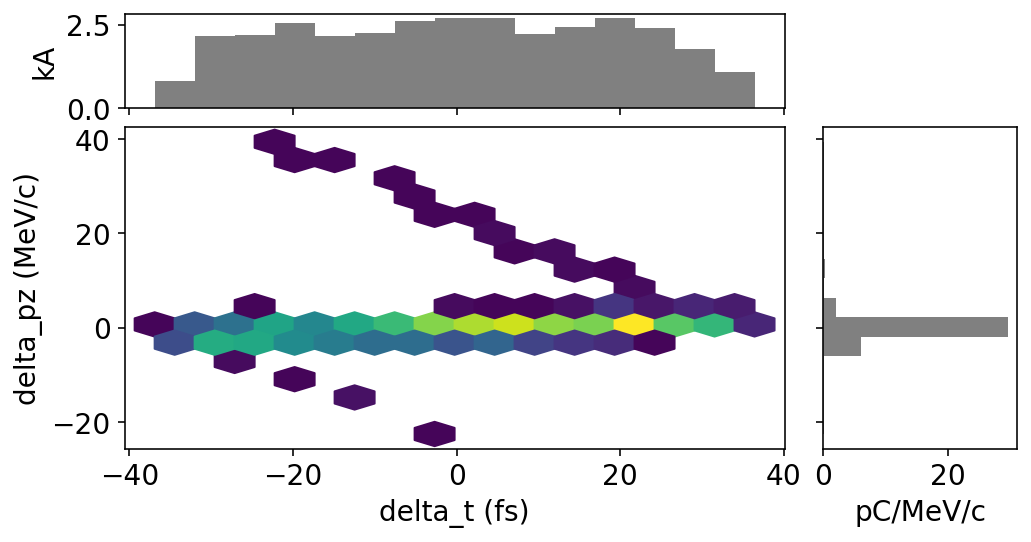

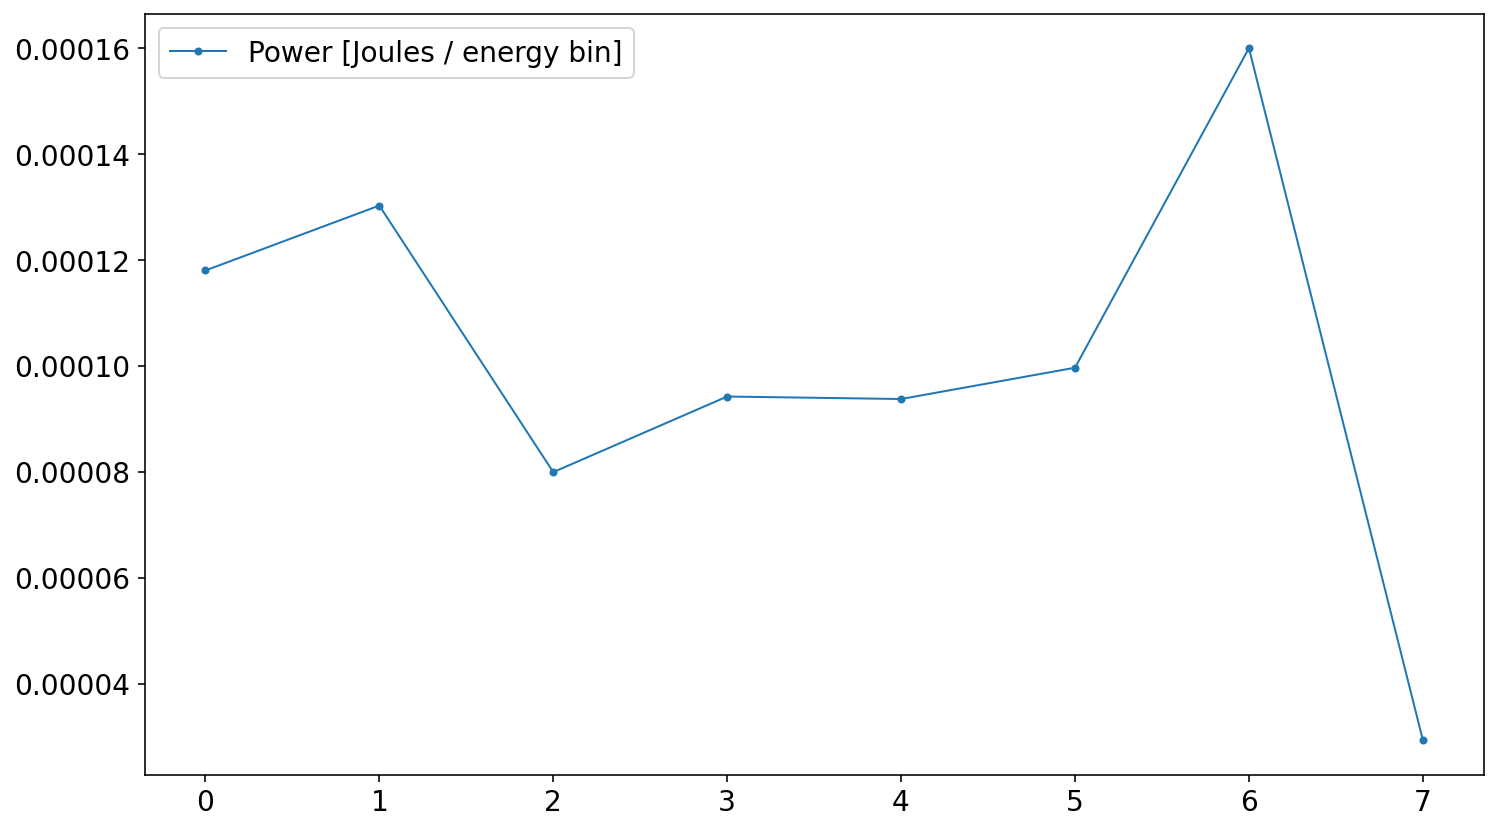

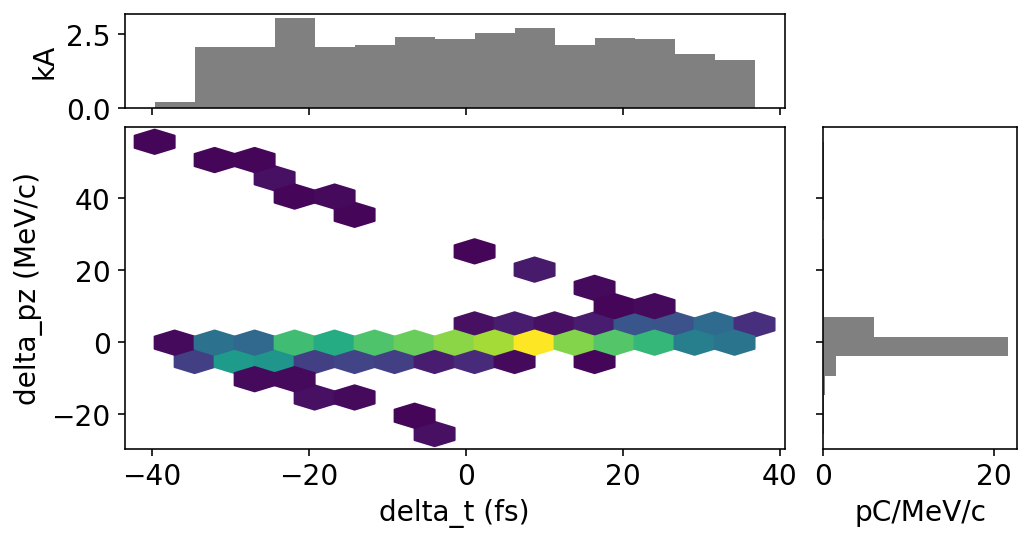

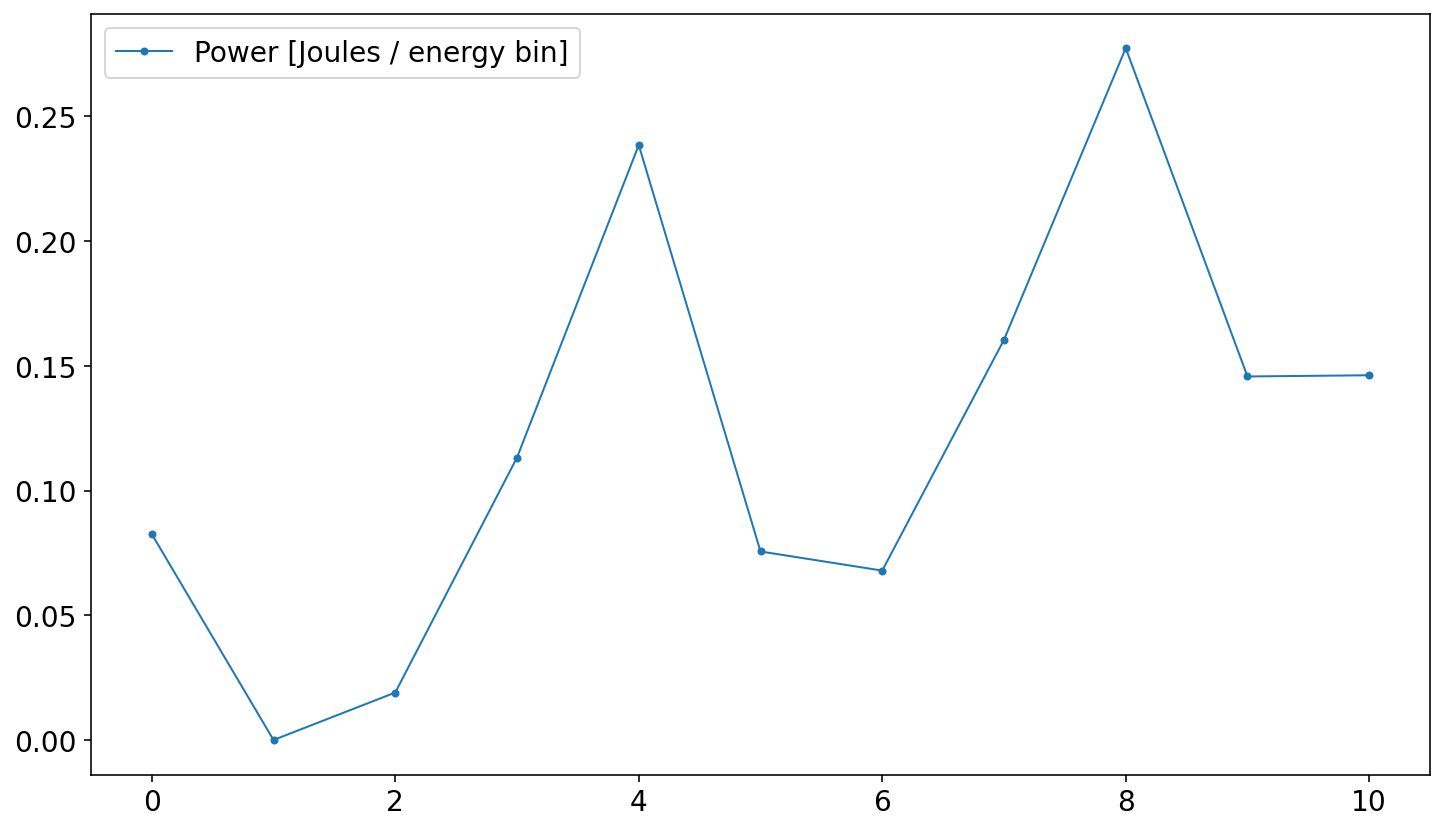

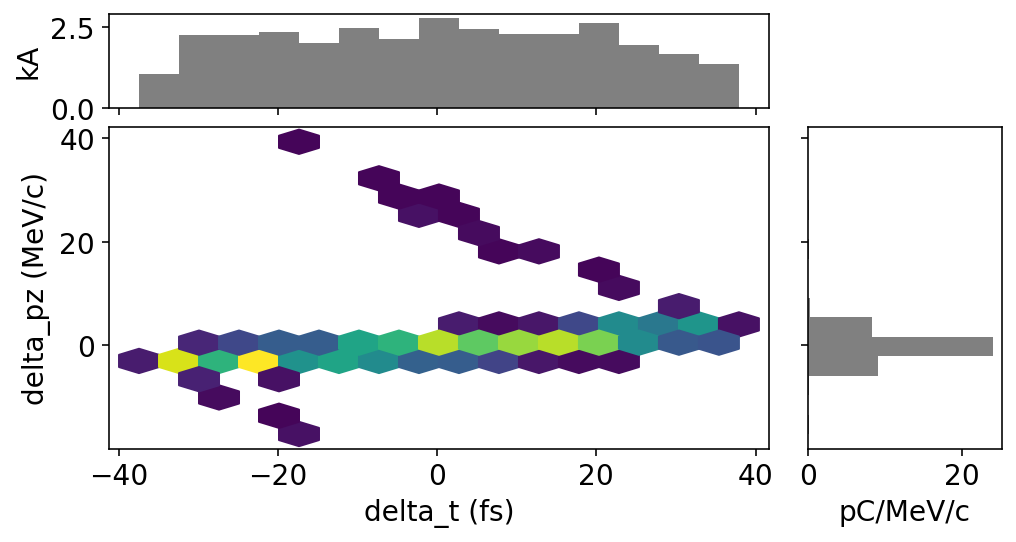

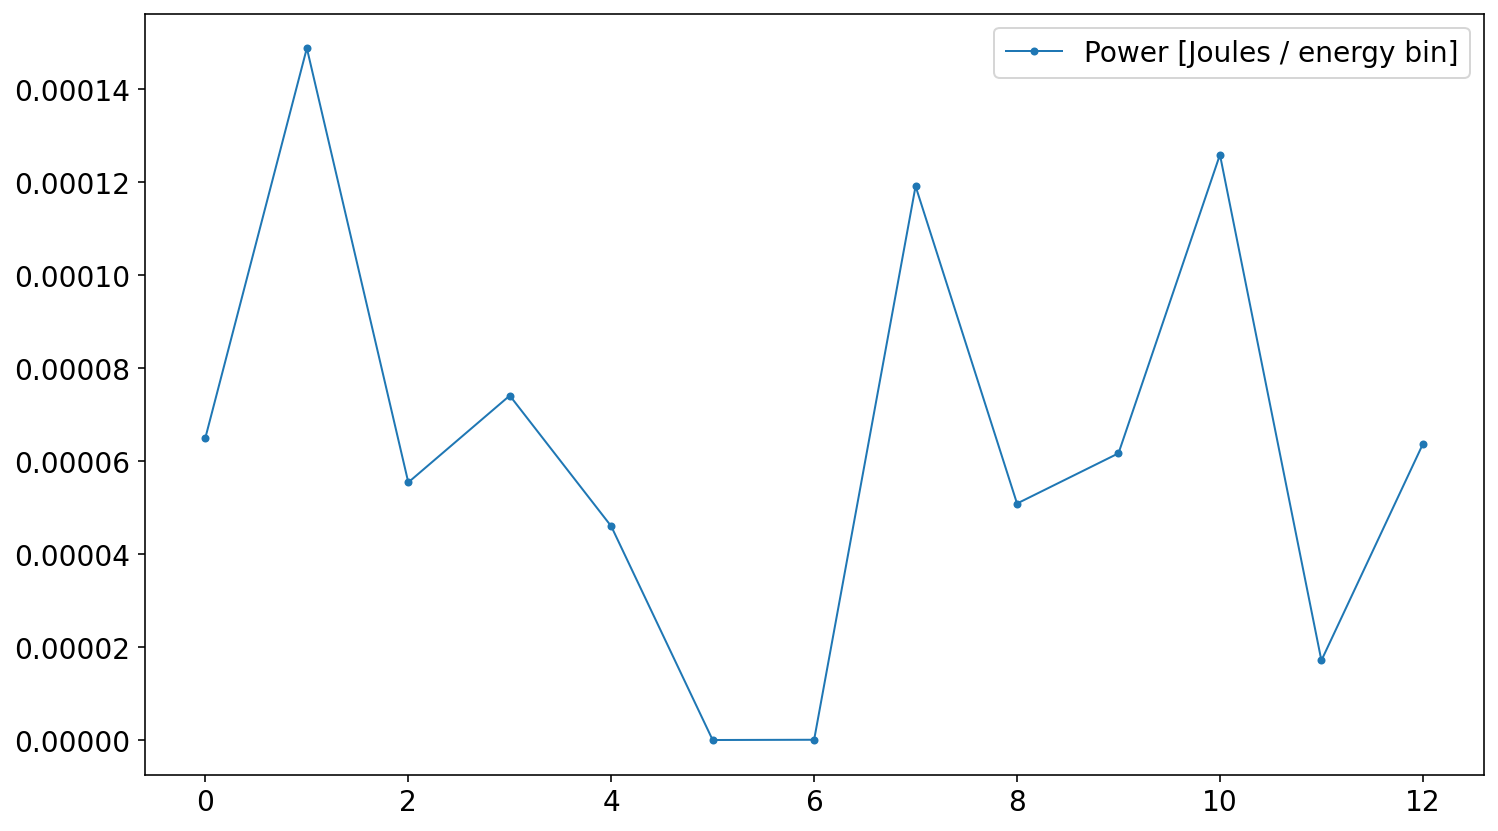

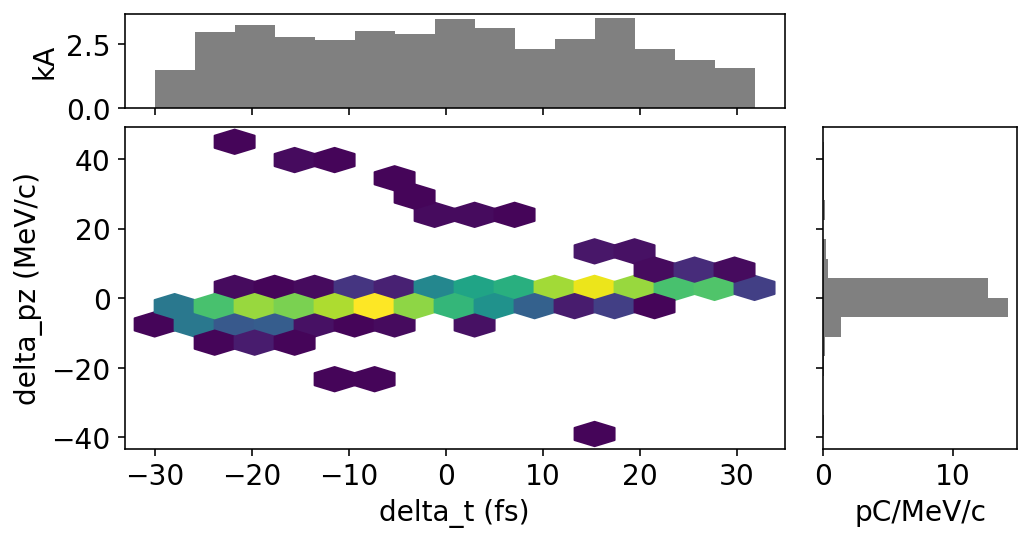

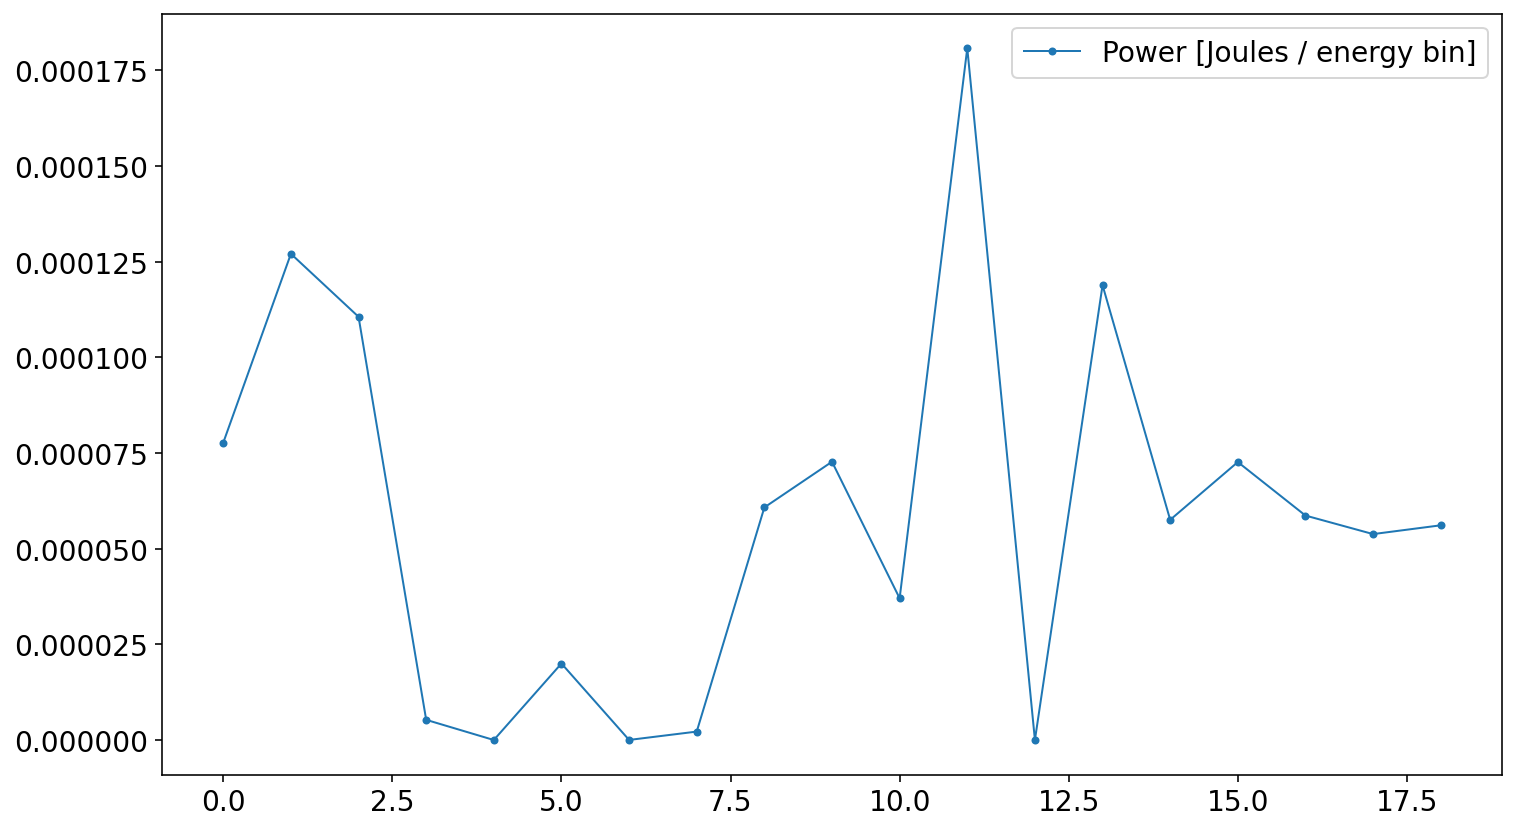

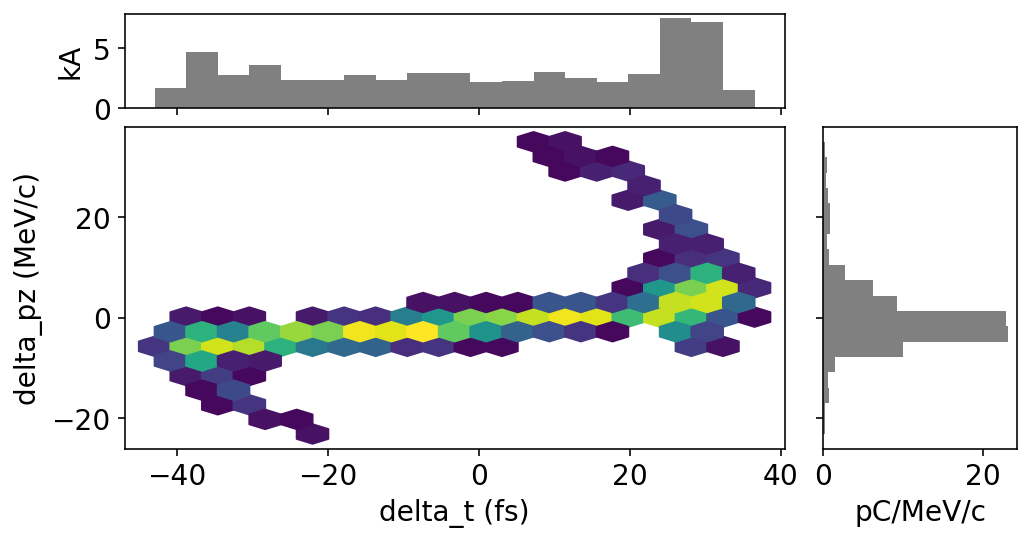

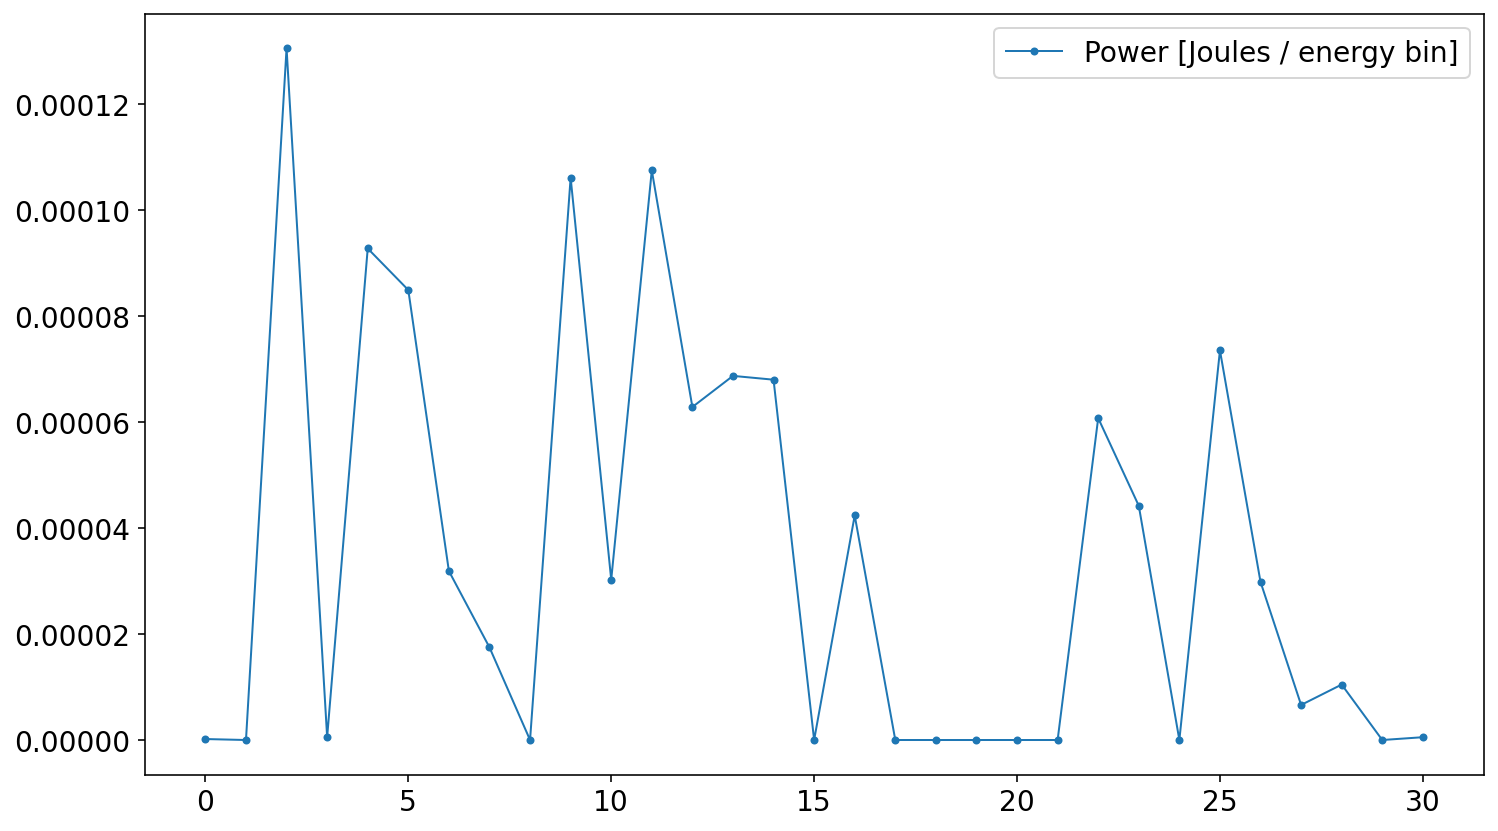

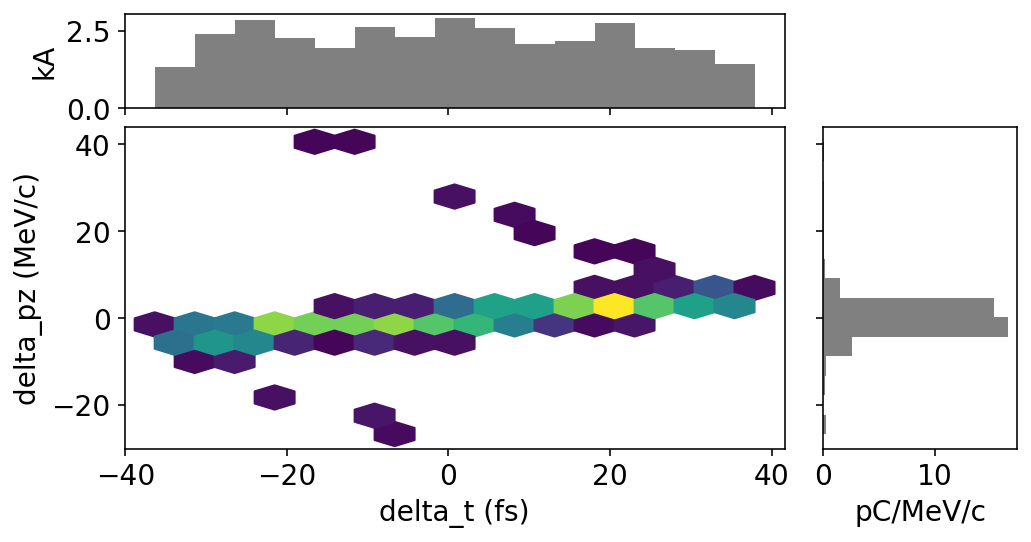

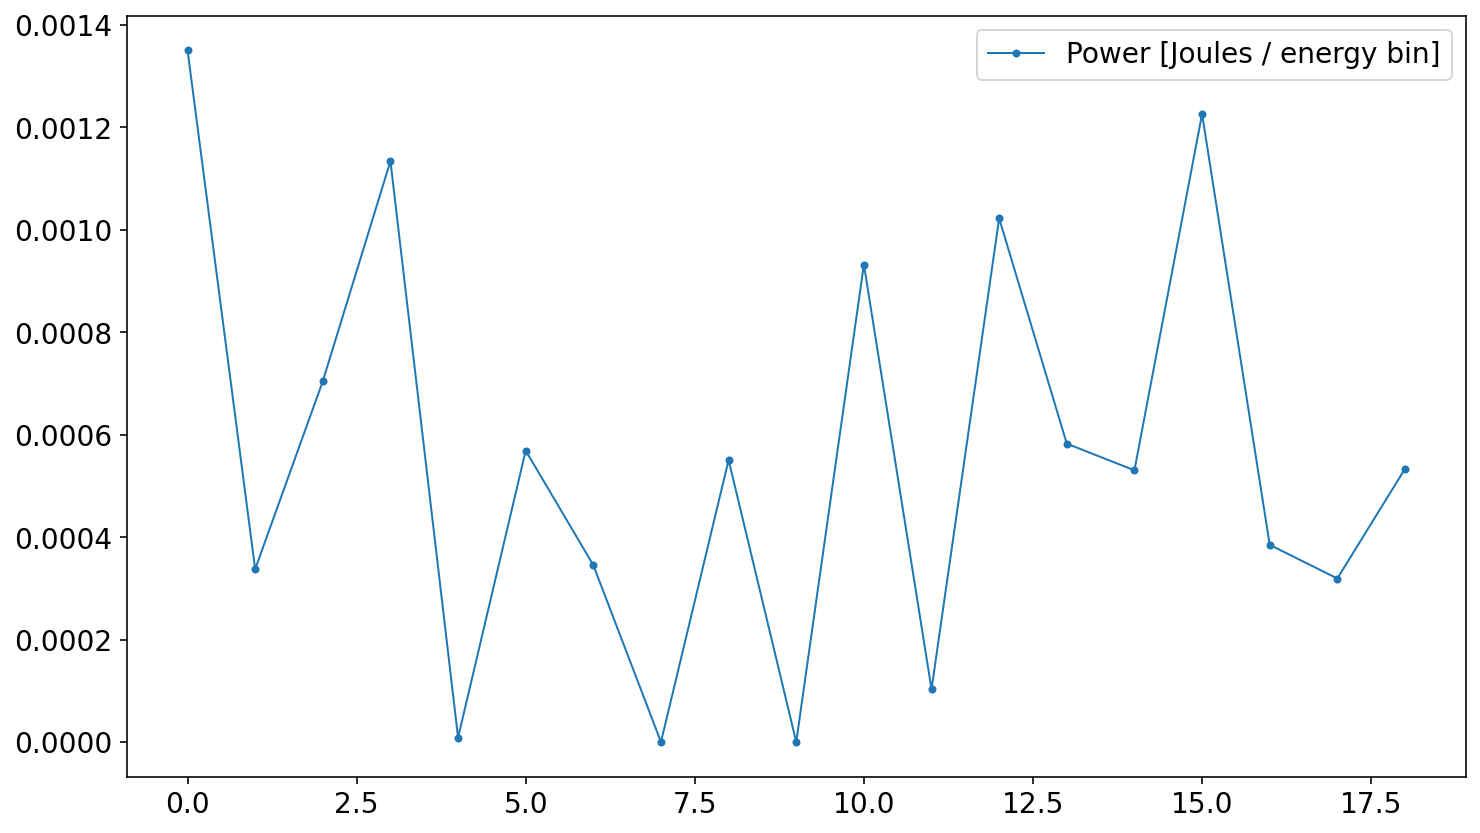

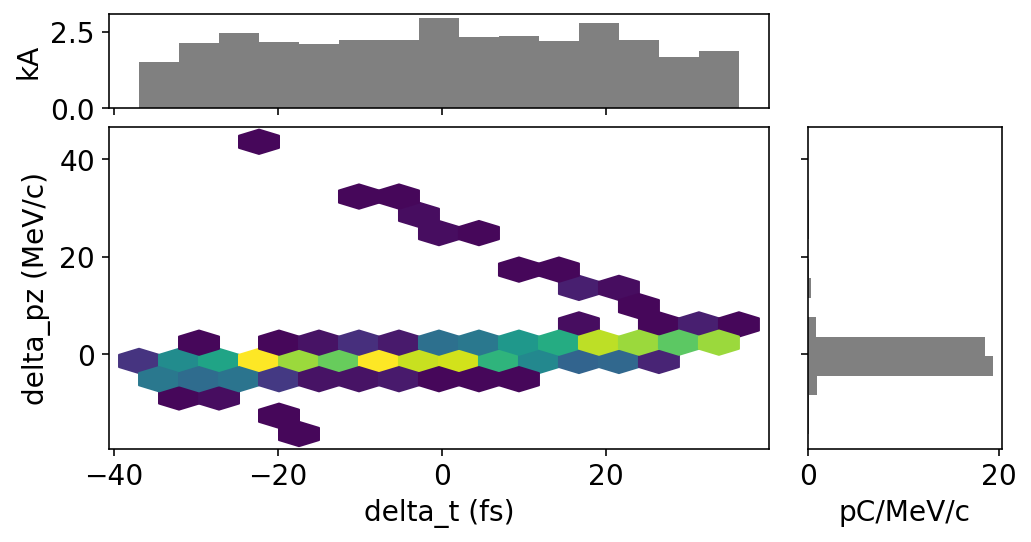

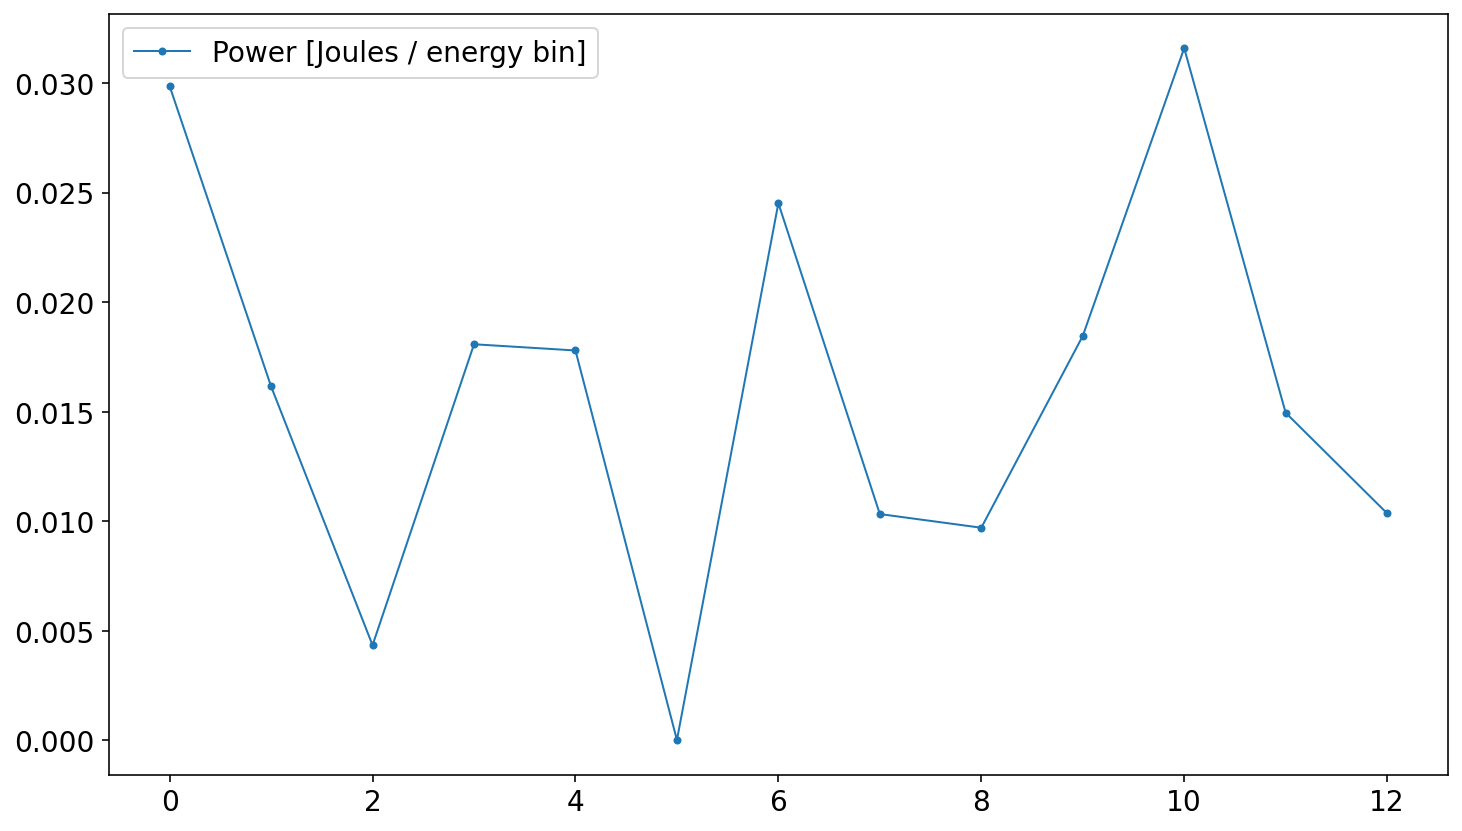

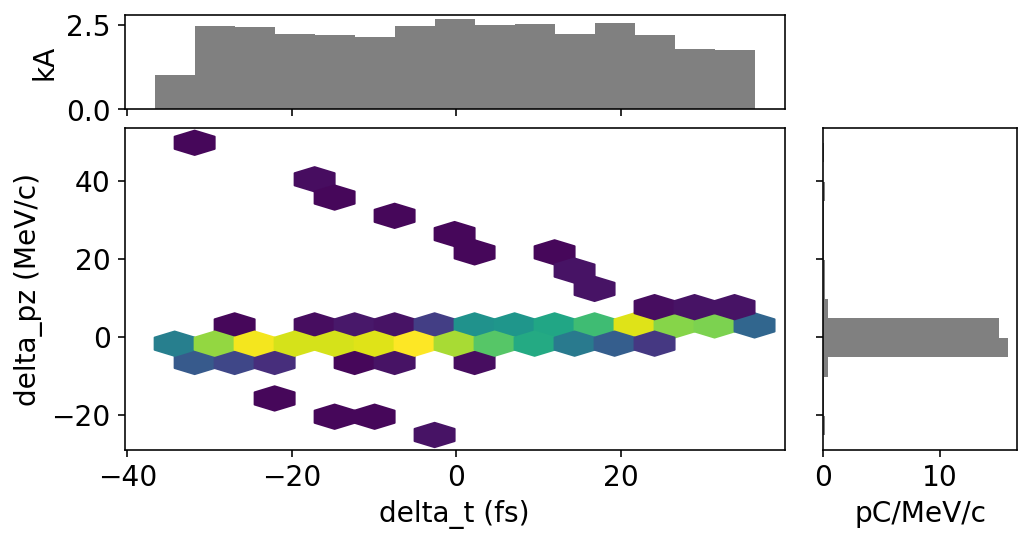

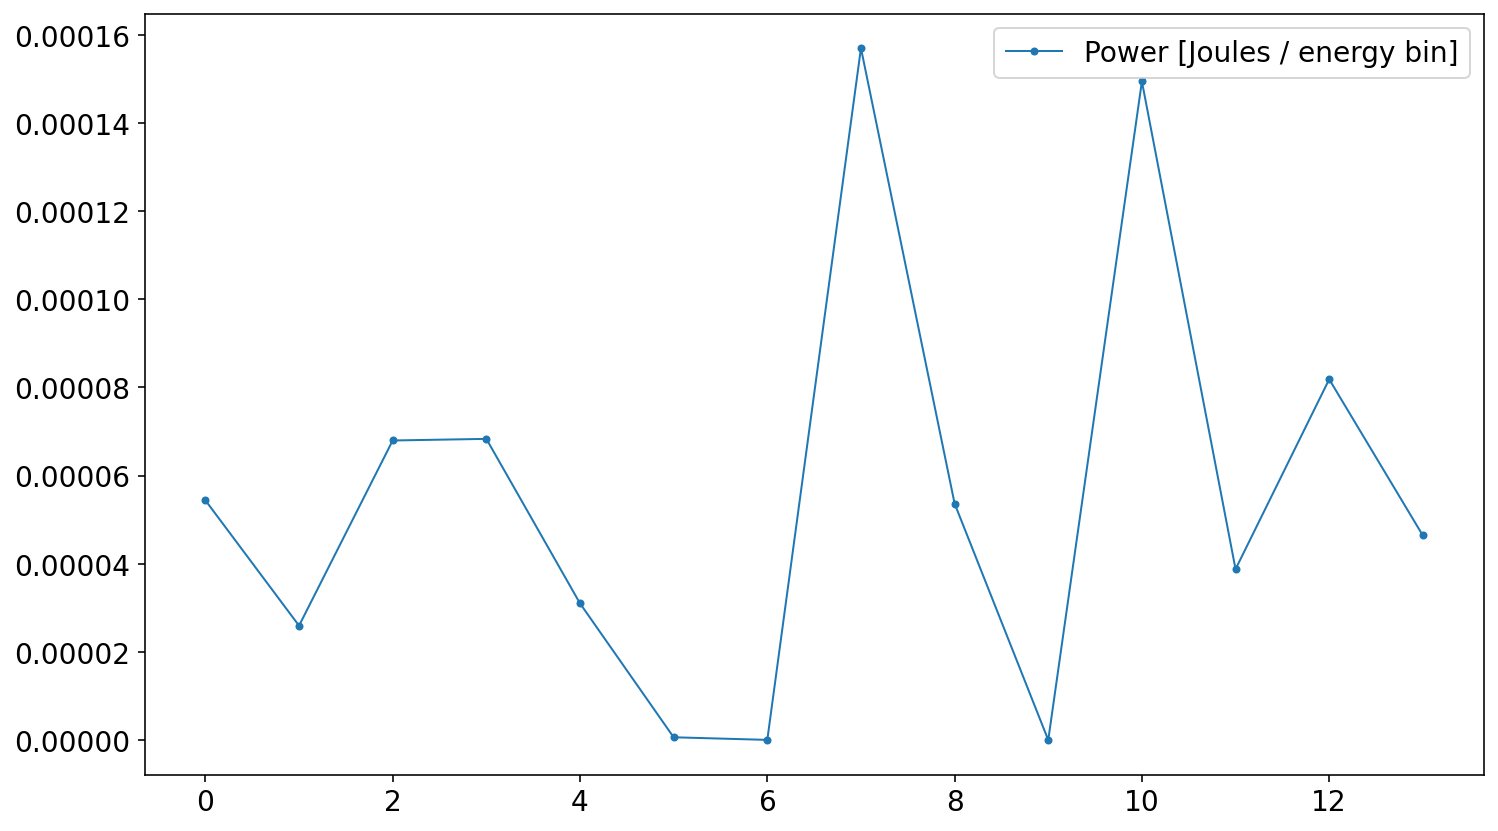

In [50]:
var_lim = [1-1/100, 1+1/100]
pbounds = {'var1': (l1_phase_init*var_lim[1], l1_phase_init*var_lim[0]), # init -21.5
           'var1x': (l1x_phase_init*var_lim[1], l1x_phase_init*var_lim[0]), # init -160.0
           'var2': (l2_phase_init*var_lim[1], l2_phase_init*var_lim[0])} # init -33.5

optimizer = BayesianOptimization(
    f = evaluate,
    pbounds = pbounds,
    random_state = 1,
)

optimizer.maximize(
    init_points=3,
    n_iter=5,
)